<a href="https://colab.research.google.com/github/atishayj4in/Multilingual_Audio_Classifier/blob/main/MultilingualAudioClassifier_by_Atishay_Jain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Multilingual Audio Classifier by Atishay Jain***

---

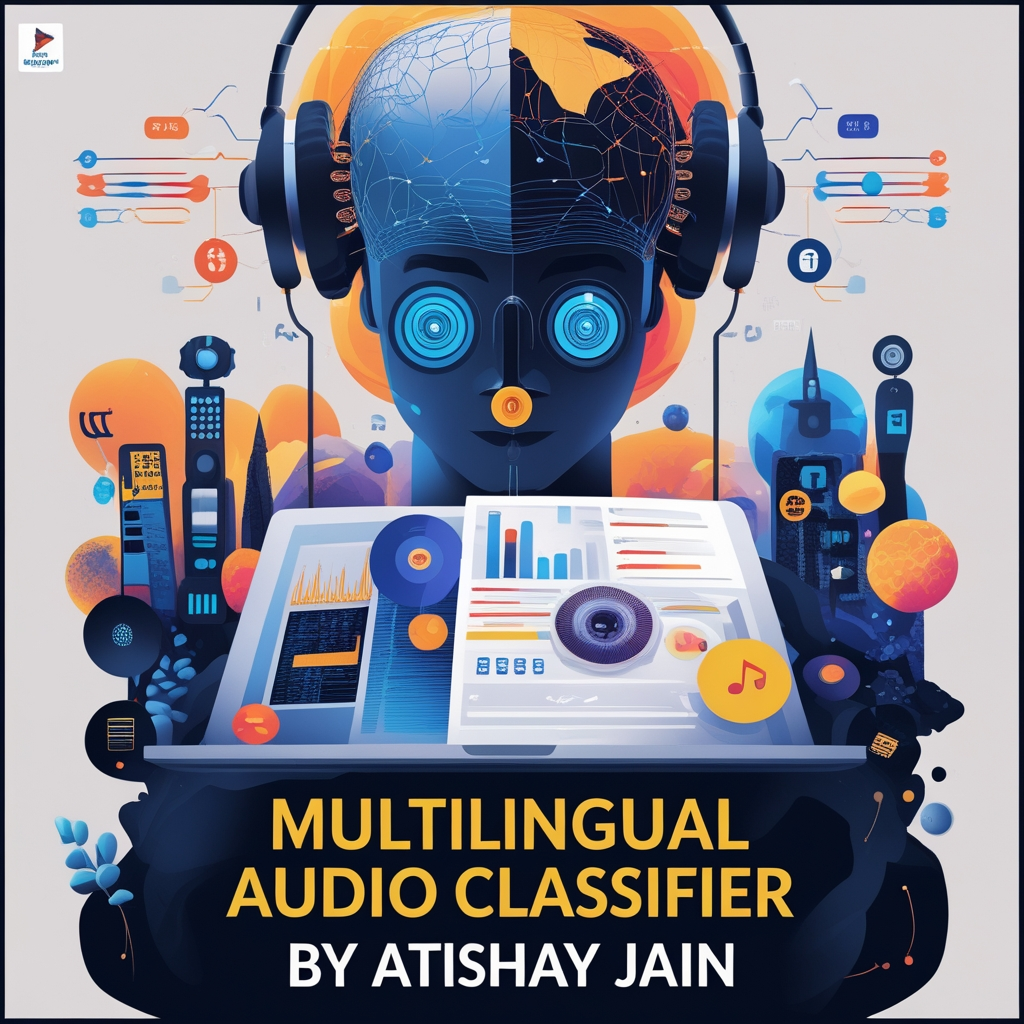

---


In [ ]:
import numpy
import pandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive

file_path = "//content//drive//MyDrive//Data//Dataset//0Info.txt"
with open(file_path, 'r') as file:
    content = file.read()
    print(content)

JP_0000.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,10:27,JP
JP_0001.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,02:23,JP
JP_0002.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,04:54,JP
JP_0003.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,10:03,JP
JP_0004.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,01:07,JP
JP_0005.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,13:05,JP
JP_0006.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,11:04,JP
JP_0007.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,14:50,JP
JP_0008.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,07:32,JP
JP_0009.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,10:38,JP
JP_0010.wav,https://youtu.be/CEPH5eisyqo?list=PLsRNoUx8w3rOHjXIU5EE4KOiIagv9yQaG,07:49,JP
JP_0011.wa

In [ ]:
audio_path=[]
labels=[]
for name in content.strip().split('\n'):
    file_name = name.split(',')[0]
    labels.append(name.split(',')[3])
    audio_path.append(os.path.join(r"//content//drive//MyDrive//Data//Dataset//" , file_name))

audio_path

['//content//drive//MyDrive//Data//Dataset//JP_0000.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0001.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0002.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0003.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0004.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0005.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0006.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0007.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0008.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0009.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0010.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0011.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0012.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0013.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0014.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0015.wav',
 '//content//drive//MyDrive//Data//Dataset//JP_0016.wav',
 '//content//d

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=None, mono=False)
    if wav.ndim > 1:
        wav = librosa.to_mono(wav)
    wav_16k = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
    return wav_16k, 16000

# def create_spectrogram(audio, sample_rate):
#     S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)
#     log_S = librosa.power_to_db(S, ref=np.max)
#     return log_S

def create_spectrogram(audio, sample_rate):
    # Create Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)

    # Convert to decibel scale
    log_S = librosa.power_to_db(S, ref=np.max)
    print(log_S)

    log_S = (log_S)

    return log_S


def resize_spectrogram(spectrogram, target_height=128, target_width=128):
    # Ensure the spectrogram has an extra channel dimension
    spectrogram = np.expand_dims(spectrogram, axis=-1)  # Shape: (height, width, 1)

    # Convert to tensor and resize
    spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
    spectrogram_resized = tf.image.resize(spectrogram, [target_height, target_width], method='bilinear')

    # Remove the single channel dimension
    return spectrogram_resized[..., 0].numpy()  # Shape: (target_height, target_width)

def convert_to_rgb(spectrogram):
    # Convert single-channel spectrogram to 3-channel (RGB)
    return np.stack([spectrogram] * 3, axis=-1)  # Shape: (height, width, 3)

def preprocess_audio_files(audio_paths, labels):
    spectrograms = []
    for path in audio_paths:
        audio, sr = load_wav_16k_mono(path)
        spectrogram = create_spectrogram(audio, sr)

        spectrogram_resized = resize_spectrogram(spectrogram, target_height=128, target_width=128)

        spectrogram_rgb = convert_to_rgb(spectrogram_resized)


        spectrograms.append(spectrogram_rgb)

    # Convert lists to numpy arrays
    return np.array(spectrograms), labels

[[-44.44956  -46.77804  -49.95259  ... -38.478058 -42.344982 -42.014114]
 [-43.737587 -44.64792  -44.398655 ... -41.53279  -44.439663 -37.546722]
 [-33.070526 -35.672237 -43.736076 ... -43.153587 -42.413795 -34.092514]
 ...
 [-73.57388  -71.57948  -70.54323  ... -64.37272  -67.10076  -64.418396]
 [-71.72633  -70.90727  -68.41235  ... -61.87126  -64.95795  -63.2368  ]
 [-71.08226  -69.9362   -68.53029  ... -59.847134 -62.689747 -62.17135 ]]


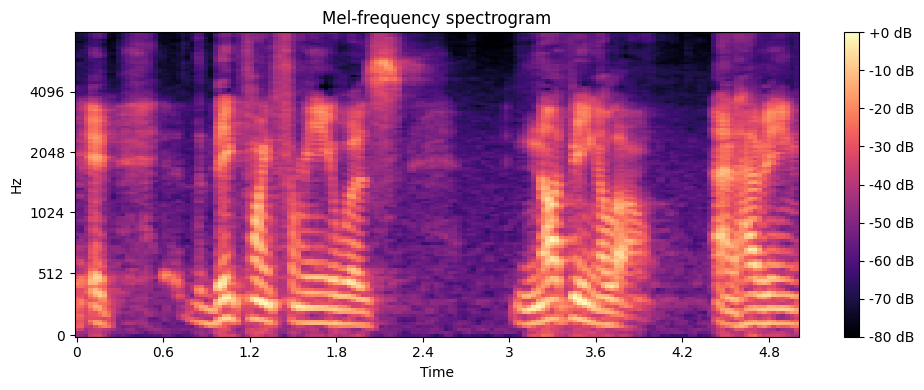

In [ ]:
#example mel_spectrogram
def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

filename = '//content//drive//MyDrive//Data//Dataset//EN_0014.wav'
audio, sample_rate = load_wav_16k_mono(filename)
spectrogram = create_spectrogram(audio, sample_rate)
plot_spectrogram(spectrogram)

In [ ]:
from sklearn.preprocessing import LabelEncoder

spectrograms, labels = preprocess_audio_files(audio_path, labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

X_train, X_val, y_train, y_val = train_test_split(spectrograms, y_encoded, test_size=0.2, random_state=42)

Streaming output truncated to the last 5000 lines.
 [-51.294212 -53.616684 -64.3936   ... -48.832977 -47.869778 -53.160942]
 [-47.703472 -50.18998  -62.37898  ... -50.62246  -47.757835 -51.991493]]
[[-34.61621  -36.55807  -36.069008 ... -40.762085 -32.036613 -30.935116]
 [-37.40505  -39.5159   -40.301857 ... -46.296677 -34.57663  -33.035328]
 [-38.974274 -44.54796  -56.58442  ... -47.012405 -35.19162  -33.25137 ]
 ...
 [-63.90151  -58.859528 -55.644173 ... -69.41943  -54.741158 -46.45759 ]
 [-64.93613  -60.194916 -57.409935 ... -70.74603  -56.56692  -48.044876]
 [-61.80697  -61.096214 -60.207012 ... -72.842224 -59.4986   -50.480488]]
[[-44.01492  -46.933582 -42.113644 ... -38.019073 -38.31279  -33.733635]
 [-50.129204 -53.72399  -55.467957 ... -43.789543 -40.925484 -40.260353]
 [-52.661728 -55.75228  -55.92879  ... -46.82196  -44.75058  -46.304005]
 ...
 [-58.729797 -58.467155 -66.22603  ... -54.850822 -55.75992  -55.32738 ]
 [-56.856014 -58.02797  -67.174805 ... -60.118988 -60.252125 

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape and number of classes
input_shape = (128, 128, 3)  # RGB images
num_classes = len(np.unique(y_encoded))  # Number of unique classes in your dataset

# Create and compile the model
model = create_model(input_shape, num_classes)

# Print the model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using encoded labels
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # Increase epochs as needed
    batch_size=32,
    callbacks=[early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4369 - loss: 1.9020 - val_accuracy: 0.2200 - val_loss: 263.9710
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.7232 - loss: 0.8406 - val_accuracy: 0.3100 - val_loss: 10.6664
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7678 - loss: 0.6103 - val_accuracy: 0.3350 - val_loss: 5.6000
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8801 - loss: 0.3517 - val_accuracy: 0.4400 - val_loss: 4.5339
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9074 - loss: 0.2692 - val_accuracy: 0.3450 - val_loss: 5.0184
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9612 - loss: 0.1573 - val_accuracy: 0.5350 - val_loss: 3.9575
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9452 - loss: 0.1540 - val_accuracy: 0.6250 - val_loss: 3.1126
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9790 - loss: 0.0754 - val_accuracy: 

In [ ]:
model.save("//content//drive//MyDrive//Data//Dataset//language.keras")

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 92.00%


In [ ]:
def preprocess_single_audio_file(audio_path, input_shape):

    audio, sr = load_wav_16k_mono(audio_path)
    spectrogram = create_spectrogram(audio, sr)
    spectrogram_resized = resize_spectrogram(spectrogram, target_height=input_shape[0], target_width=input_shape[1])
    spectrogram_rgb = convert_to_rgb(spectrogram_resized)

    return spectrogram_rgb

def predict_with_model(model, audio_path, input_shape):

    spectrogram_rgb = preprocess_single_audio_file(audio_path, input_shape)

    spectrogram_rgb_batch = np.expand_dims(spectrogram_rgb, axis=0)  # Shape: (1, height, width, channels)
    predictions = model.predict(spectrogram_rgb_batch)

    predicted_class_index = np.argmax(predictions, axis=1)[0]

    class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return class_label

In [ ]:
def preprocess_single_audio_file(audio_path, input_shape):

    audio, sr = load_wav_16k_mono(audio_path)
    spectrogram = create_spectrogram(audio, sr)
    spectrogram_resized = resize_spectrogram(spectrogram, target_height=input_shape[0], target_width=input_shape[1])
    spectrogram_rgb = convert_to_rgb(spectrogram_resized)

    return spectrogram_rgb

def predict_with_model(model, audio_path, input_shape):

    spectrogram_rgb = preprocess_single_audio_file(audio_path, input_shape)

    spectrogram_rgb_batch = np.expand_dims(spectrogram_rgb, axis=0)  # Shape: (1, height, width, channels)
    predictions = model.predict(spectrogram_rgb_batch)

    predicted_class_index = np.argmax(predictions, axis=1)[0]

    class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return class_label

audio_path =  '//content//drive//MyDrive//Data//Dataset//EN_0014.wav'
input_shape = (128, 128, 3)  # The input shape expected by your model

predicted_class = predict_with_model(model, audio_path, input_shape)
print(f"Predicted class: {predicted_class}")

[[-44.44956  -46.77804  -49.95259  ... -38.478058 -42.344982 -42.014114]
 [-43.737587 -44.64792  -44.398655 ... -41.53279  -44.439663 -37.546722]
 [-33.070526 -35.672237 -43.736076 ... -43.153587 -42.413795 -34.092514]
 ...
 [-73.57388  -71.57948  -70.54323  ... -64.37272  -67.10076  -64.418396]
 [-71.72633  -70.90727  -68.41235  ... -61.87126  -64.95795  -63.2368  ]
 [-71.08226  -69.9362   -68.53029  ... -59.847134 -62.689747 -62.17135 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: EN
